# PyPortfolioOpt vs CVXPY in Portfolio Optimization  

When building optimized portfolios, it is often best to **start with PyPortfolioOpt** because it provides a high-level, finance-focused interface for implementing Modern Portfolio Theory (MPT), Black-Litterman, and Hierarchical Risk Parity.  

However, as strategies grow more complex and require custom constraints, it becomes important to transition into **CVXPY**, a low-level optimization framework that gives full flexibility to design mathematical optimization problems.  

---

## 1. PyPortfolioOpt  

**Purpose**  
A specialized Python library for portfolio optimization in quantitative finance.  

**Level of Abstraction**  
High-level (finance-focused).  

**What it Does**  
- Provides ready-made tools for mean-variance optimization, Black-Litterman model, hierarchical risk parity (HRP), etc.  
- Helps construct efficient frontiers, optimize for Sharpe ratio, minimize volatility, etc.  
- Abstracts away most of the math/optimization setup — you just provide historical returns, covariance matrices, and constraints.  

**Under the Hood**  
Uses optimization solvers (often via CVXPY or `scipy.optimize`) to solve the actual mathematical problems.  

**Best For**  
- Financial analysts, quants, or data scientists who want to quickly apply portfolio theory without coding the optimization math themselves.  

---

## 2. CVXPY  

**Purpose**  
A general convex optimization modeling framework in Python.  

**Level of Abstraction**  
Low-level (math/optimization-focused).  

**What it Does**  
- Lets you formulate and solve **any convex optimization problem** (not just finance).  
- Provides a domain-specific language (DSL) to express optimization problems in a way similar to mathematical notation.  
- Supports multiple solvers (ECOS, SCS, OSQP, MOSEK, GUROBI, etc.).  

**Best For**  
- Researchers, engineers, or quants who need flexibility to design **custom optimization problems** beyond the templates PyPortfolioOpt provides.  
- Cases where you need **nonlinear constraints, integer variables, or advanced formulations**.  

---

## 3. Key Difference  

- **PyPortfolioOpt** = domain-specific, finance-first, “batteries included.”  
- **CVXPY** = domain-agnostic, optimization-first, highly flexible.  

In fact, can think of **PyPortfolioOpt as a wrapper around CVXPY (and other solvers)**, specialized for portfolio optimization.  


In [3]:
"""
mvo_max_sharpe_cvxpy.py

Requirements:
    pip install yfinance pandas numpy matplotlib cvxpy
    (optional) pip install openpyxl   # if you want to save excel outputs

Usage:
    python mvo_max_sharpe_cvxpy.py
"""
#!pip install cvxpy --quiet

import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import cvxpy as cp

# Jupyter notebook reporting cells
# (Run these after executing the optimization script setup)

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

In [2]:
# Try to import yfinance; if not available, inform user
try:
    import yfinance as yf
    YFINANCE_AVAILABLE = True
except Exception:
    YFINANCE_AVAILABLE = False
    print("yfinance not available. The script will offer to use simulated data instead.")


# -----------------------
# User-configurable params
# -----------------------
START_DATE = "2022-01-01"   # change as desired
END_DATE = datetime.date.today().isoformat()
LOOKBACK_YEARS = 3
RISK_FREE_RATE = 0.06  # annual risk-free rate (6%); adjust to your desired RF
TRADING_DAYS_PER_YEAR = 252
TARGET_POINTS = 50  # how many points on the efficient frontier to compute
RESULTS_DIR = "mvo_results"
os.makedirs(RESULTS_DIR, exist_ok=True)


# -----------------------
# Sample list of NIFTY 50 tickers (Yahoo style)
# (Note: Yahoo tickers for Indian stocks often include .NS like "RELIANCE.NS")
# Replace or trim this list based on availability / your preference
# -----------------------
nifty50_sample = [
    "RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "ICICIBANK.NS", "HINDUNILVR.NS",
    "INFY.NS", "KOTAKBANK.NS", "SBIN.NS", "AXISBANK.NS", "LT.NS", "ITC.NS", "BAJFINANCE.NS", "BHARTIARTL.NS", "ASIANPAINT.NS",
    "MARUTI.NS", "NTPC.NS", "JSWSTEEL.NS", "ONGC.NS", "SUNPHARMA.NS"
]
tickers = nifty50_sample  # you can edit / reduce this list


# -----------------------
# Download prices or fallback to simulated data
# -----------------------
def download_prices(tick_list, start, end):
    if not YFINANCE_AVAILABLE:
        raise RuntimeError("yfinance is not installed or importable.")
    print(f"Downloading adjusted close prices for {len(tick_list)} tickers from {start} to {end} ...")
    data = yf.download(tick_list, start=start, end=end, progress=False, threads=True, auto_adjust=False)
    if data.empty:
        raise RuntimeError("Downloaded data is empty. Check tickers or network.")
    # auto_adjust=True gives adjusted close in 'Close' column; if multi-column, pick 'Close' or 'Adj Close'.
    if isinstance(data, pd.DataFrame) and ("Adj Close" in data.columns or "Close" in data.columns):
        # yfinance sometimes returns single-level columns if one ticker; handle both cases
        if ("Adj Close" in data.columns) and isinstance(data.columns, pd.MultiIndex):
            prices = data["Adj Close"].copy()
        elif ("Close" in data.columns) and isinstance(data.columns, pd.MultiIndex):
            prices = data["Close"].copy()
        elif "Adj Close" in data.columns:
            prices = data["Adj Close"].copy()
        elif "Close" in data.columns:
            prices = data["Close"].copy()
        else:
            prices = data.copy()
    else:
        # If we get a single-column series or just a DataFrame with tickers as columns, try to coerce
        prices = data.copy()
    # Ensure columns are tickers
    prices = prices.dropna(how="all", axis=1)
    # Some tickers may fail; keep the ones with sufficient data
    # Drop columns with too many NaNs
    min_obs = int(TRADING_DAYS_PER_YEAR * 0.5)  # at least half year of observations
    valid_cols = [c for c in prices.columns if prices[c].dropna().shape[0] >= min_obs]
    prices = prices[valid_cols].copy()
    prices = prices.ffill().bfill()
    return prices


def make_simulated_prices(n_assets=10, n_days=TRADING_DAYS_PER_YEAR*3, seed=123):
    # Geometric Brownian Motion simulated prices
    rng = np.random.default_rng(seed)
    dt = 1/ TRADING_DAYS_PER_YEAR
    mu = rng.normal(0.08, 0.02, size=n_assets)  # annual drift ~8%
    sigma = rng.uniform(0.15, 0.4, size=n_assets)
    S0 = rng.uniform(50, 500, size=n_assets)
    returns = rng.normal(loc=(mu*dt), scale=(sigma*np.sqrt(dt)), size=(n_days, n_assets))
    logS = np.log(S0) + returns.cumsum(axis=0)
    prices = np.exp(logS)
    dates = pd.bdate_range(end=datetime.date.today(), periods=n_days)
    cols = [f"SIM_{i+1}" for i in range(n_assets)]
    return pd.DataFrame(prices, index=dates, columns=cols)


# Attempt download
try:
    prices = download_prices(tickers, START_DATE, END_DATE)
    if prices.shape[1] < 2:
        print("Warning: less than 2 assets downloaded. Switching to simulated data.")
        prices = make_simulated_prices(n_assets=10)
except Exception as e:
    print(f"Warning: failed to download prices: {e}")
    print("Using simulated price data instead. If you want live data, install yfinance and try again.")
    prices = make_simulated_prices(n_assets=10)


print(f"Using {prices.shape[1]} assets and {prices.shape[0]} price observations.")
assets = list(prices.columns)


# -----------------------
# Compute returns, annualized mu and covariance
# -----------------------
# Use daily log returns (or simple returns); widely used is simple returns
daily_returns = prices.pct_change().dropna(how="all")
# Remove any assets with NaN entirely
daily_returns = daily_returns.dropna(axis=1, how='all')
mean_daily = daily_returns.mean()
cov_daily = daily_returns.cov()

# Annualize
mu_annual = mean_daily * TRADING_DAYS_PER_YEAR
cov_annual = cov_daily * TRADING_DAYS_PER_YEAR

# baseline equal-weight portfolio metrics
n = len(mu_annual)
ew = np.repeat(1.0 / n, n)
ew_return = float(mu_annual.values @ ew)
ew_vol = float(np.sqrt(ew @ cov_annual.values @ ew))
ew_sharpe = (ew_return - RISK_FREE_RATE) / ew_vol

print(f"Equal-weight return (ann): {ew_return:.3%}, vol: {ew_vol:.3%}, Sharpe: {ew_sharpe:.3f}")


# -----------------------
# CVXPY QP: Minimize variance subject to target return & constraints
# We'll sweep target returns between min(mu) and max(mu) to produce frontier.
# -----------------------
Sigma = cov_annual.values
mu = mu_annual.values
n = len(mu)

# Ensure covariance matrix is symmetric PSD; add tiny ridge if needed
eps = 1e-8
Sigma = 0.5 * (Sigma + Sigma.T)
eigvals = np.linalg.eigvalsh(Sigma)
if np.min(eigvals) < 1e-10:
    ridge = (1e-6 - np.min(eigvals)) if np.min(eigvals) < 0 else 1e-6
    Sigma = Sigma + np.eye(n) * ridge

# Variables
w = cp.Variable(n)

# Constraints: long-only, fully invested
constraints = [cp.sum(w) == 1, w >= 0]

# Range of target returns
ret_min = np.min(mu)
ret_max = np.max(mu)
target_returns = np.linspace(ret_min, ret_max, TARGET_POINTS)

frontier_weights = []
frontier_risks = []
frontier_returns = []

# QP: minimize w^T Sigma w subject to mu^T w >= target, constraints
for targ in target_returns:
    obj = cp.quad_form(w, Sigma)
    prob = cp.Problem(cp.Minimize(obj),
                      constraints + [mu @ w >= targ])
    try:
        prob.solve(solver=cp.OSQP, warm_start=True, verbose=False)
    except Exception:
        try:
            prob.solve(solver=cp.SCS, warm_start=True, verbose=False)
        except Exception as e:
            # As fallback, use default solver
            prob.solve(warm_start=True, verbose=False)
    if w.value is None:
        print(f"Warning: solver failed for target={targ:.6f}. Skipping.")
        continue
    w_opt = np.array(w.value).flatten()
    # Numerical clean-up: set tiny negatives to 0
    w_opt[w_opt < 1e-8] = 0
    w_opt = w_opt / w_opt.sum()  # re-normalize to be safe
    frontier_weights.append(w_opt)
    port_return = float(mu @ w_opt)
    port_vol = float(np.sqrt(w_opt @ Sigma @ w_opt))
    frontier_returns.append(port_return)
    frontier_risks.append(port_vol)

# Convert to arrays
frontier_returns = np.array(frontier_returns)
frontier_risks = np.array(frontier_risks)
frontier_weights = np.array(frontier_weights)

# Compute Sharpe at each frontier point
sharpes = (frontier_returns - RISK_FREE_RATE) / frontier_risks
imax = np.nanargmax(sharpes)
w_star = frontier_weights[imax]
ret_star = frontier_returns[imax]
vol_star = frontier_risks[imax]
sharpe_star = sharpes[imax]

print("\nMaximum-Sharpe portfolio (from frontier sweep):")
for a, wt in zip(assets, w_star):
    if wt > 1e-4:
        print(f"  {a:15s}: {wt:.4f}")
print(f"Annual Return: {ret_star:.3%}")
print(f"Annual Volatility: {vol_star:.3%}")
print(f"Sharpe Ratio (ann): {sharpe_star:.3f}")

# Save the weights to CSV
weights_df = pd.DataFrame(index=assets, data=w_star, columns=["weight"])
weights_df = weights_df.sort_values("weight", ascending=False)
weights_df.to_csv(os.path.join(RESULTS_DIR, "max_sharpe_weights.csv"))

# Save frontier table
frontier_df = pd.DataFrame({
    "target_return": target_returns[:len(frontier_returns)],
    "portfolio_return": frontier_returns,
    "portfolio_volatility": frontier_risks,
    "sharpe": sharpes
})
frontier_df.to_csv(os.path.join(RESULTS_DIR, "efficient_frontier.csv"), index=False)


# -----------------------
# Construct portfolio returns series (daily) and compare to equal weight
# -----------------------
# compute daily portfolio returns using weights w_star
# align daily_returns columns with assets order used for weights
daily_returns = daily_returns[assets].dropna(axis=1, how='all')
# If any assets are missing in returns (shouldn't), align
common_assets = [a for a in assets if a in daily_returns.columns]
if len(common_assets) != len(assets):
    print("Note: some assets missing in daily returns; re-aligning.")
    assets = common_assets
    w_star = np.array([weights_df.loc[a, "weight"] if a in weights_df.index else 0.0 for a in assets])
    w_star = w_star / w_star.sum()

port_daily = daily_returns[assets].values @ w_star
equally_daily = daily_returns[assets].values @ (np.repeat(1.0/len(assets), len(assets)))
# Build series
port_daily_series = pd.Series(port_daily, index=daily_returns.index)
ew_daily_series = pd.Series(equally_daily, index=daily_returns.index)

# Compute cumulative returns
port_cum = (1 + port_daily_series).cumprod() - 1
ew_cum = (1 + ew_daily_series).cumprod() - 1

# -----------------------
# Plots: Efficient frontier, Weights bar chart, cumulative returns
# -----------------------
plt.figure(figsize=(8,6))
plt.plot(frontier_risks, frontier_returns, label="Efficient Frontier", linewidth=2)
plt.scatter(frontier_risks[imax], frontier_returns[imax], color='red', s=80, label="Max Sharpe")
plt.scatter(ew_vol, ew_return, color='gray', s=40, label="Equal Weight")
plt.xlabel("Annual Volatility")
plt.ylabel("Annual Return")
plt.title("Efficient Frontier (long-only)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "efficient_frontier.png"), dpi=200)
plt.close()

# Weights bar chart
plt.figure(figsize=(10,6))
inds = np.arange(len(assets))
plt.bar(inds, w_star, align='center')
plt.xticks(inds, assets, rotation=45, ha='right')
plt.ylabel("Weight")
plt.title("Max-Sharpe Portfolio Weights (long-only)")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "max_sharpe_weights.png"), dpi=200)
plt.close()

# Cumulative returns
plt.figure(figsize=(8,6))
plt.plot(port_cum.index, port_cum.values, label="Max-Sharpe Portfolio")
plt.plot(ew_cum.index, ew_cum.values, label="Equal Weight")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "cumulative_returns.png"), dpi=200)
plt.close()

# -----------------------
# Save a small report CSV/summary
# -----------------------
summary = {
    "n_assets": len(assets),
    "start_date": str(daily_returns.index[0].date()),
    "end_date": str(daily_returns.index[-1].date()),
    "equal_weight_return": ew_return,
    "equal_weight_vol": ew_vol,
    "equal_weight_sharpe": ew_sharpe,
    "max_sharpe_return": ret_star,
    "max_sharpe_vol": vol_star,
    "max_sharpe": sharpe_star
}
summary_df = pd.DataFrame.from_dict(summary, orient="index", columns=["value"])
summary_df.to_csv(os.path.join(RESULTS_DIR, "summary_metrics.csv"))

print(f"\nPlots and CSV outputs saved to folder: {RESULTS_DIR}")
print("Files include: efficient_frontier.png, max_sharpe_weights.png, cumulative_returns.png,")
print("max_sharpe_weights.csv, efficient_frontier.csv, summary_metrics.csv")

# Optionally display top holdings:
print("\nTop 10 holdings (max-sharpe):")
print(weights_df.head(10).to_string(float_format=lambda x: f"{x:.4f}"))

# End


Using 19 assets and 922 price observations.
Equal-weight return (ann): 15.433%, vol: 13.262%, Sharpe: 0.711

Maximum-Sharpe portfolio (from frontier sweep):
  BHARTIARTL.NS  : 0.3179
  ITC.NS         : 0.2110
  MARUTI.NS      : 0.0977
  NTPC.NS        : 0.2315
  SUNPHARMA.NS   : 0.1419
Annual Return: 27.989%
Annual Volatility: 14.172%
Sharpe Ratio (ann): 1.552

Plots and CSV outputs saved to folder: mvo_results
Files include: efficient_frontier.png, max_sharpe_weights.png, cumulative_returns.png,
max_sharpe_weights.csv, efficient_frontier.csv, summary_metrics.csv

Top 10 holdings (max-sharpe):
               weight
BHARTIARTL.NS  0.3179
NTPC.NS        0.2315
ITC.NS         0.2110
SUNPHARMA.NS   0.1419
MARUTI.NS      0.0977
ASIANPAINT.NS  0.0000
AXISBANK.NS    0.0000
BAJFINANCE.NS  0.0000
ICICIBANK.NS   0.0000
HINDUNILVR.NS  0.0000


## 📊 Mean-Variance Optimization Report

**Data period:** 2022-01-04 → 2025-09-23  
**Number of assets:** 19

### 📈 Key Metrics

,Return (ann),Volatility (ann),Sharpe
Equal Weight,15.43%,13.26%,0.711
Max Sharpe Portfolio,27.99%,14.17%,1.552


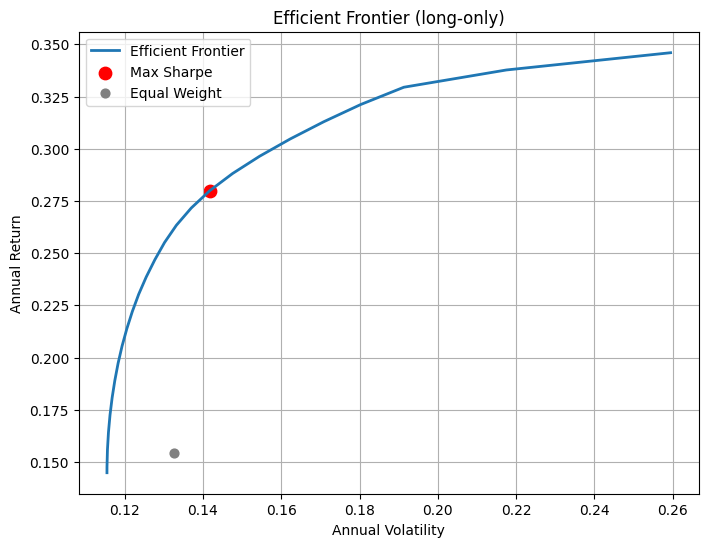

### 🧮 Max-Sharpe Portfolio Weights

,weight
BHARTIARTL.NS,31.79%
NTPC.NS,23.15%
ITC.NS,21.10%
SUNPHARMA.NS,14.19%
MARUTI.NS,9.77%
ASIANPAINT.NS,0.00%
AXISBANK.NS,0.00%
BAJFINANCE.NS,0.00%
ICICIBANK.NS,0.00%
HINDUNILVR.NS,0.00%


<Figure size 1000x600 with 0 Axes>

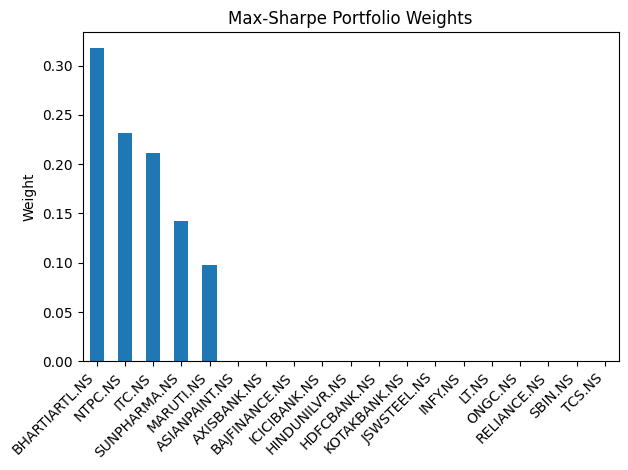

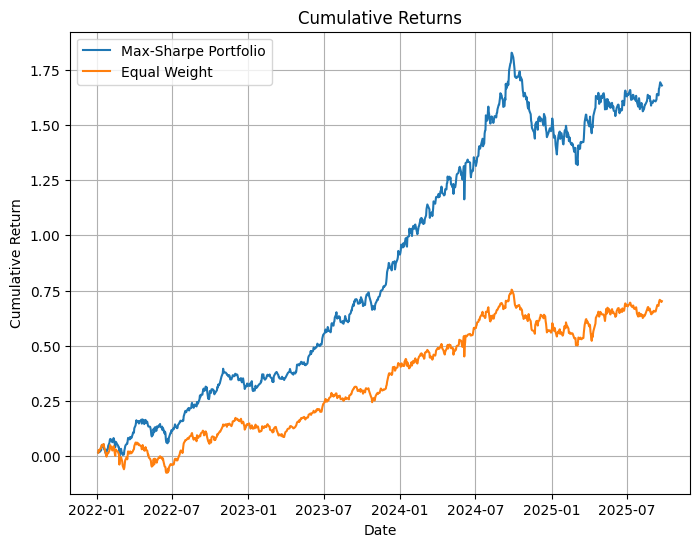

### 📑 Efficient Frontier Sample

,target_return,portfolio_return,portfolio_volatility,sharpe
40,27.16%,27.16%,13.70%,1.545
41,27.99%,27.99%,14.17%,1.552
42,28.81%,28.81%,14.76%,1.546
43,29.64%,29.64%,15.45%,1.530
44,30.47%,30.47%,16.23%,1.508
45,31.29%,31.29%,17.09%,1.480
46,32.12%,32.12%,18.03%,1.448
47,32.95%,32.95%,19.13%,1.408
48,33.77%,33.77%,21.75%,1.277
49,34.60%,34.60%,25.95%,1.102


In [6]:

# ---------------------------
# Report: Summary Header
# ---------------------------
display(Markdown("## 📊 Mean-Variance Optimization Report"))
display(Markdown(f"**Data period:** {daily_returns.index[0].date()} → {daily_returns.index[-1].date()}  \n"
                 f"**Number of assets:** {len(assets)}"))

# ---------------------------
# Show key portfolio metrics
# ---------------------------
summary_table = pd.DataFrame({
    "Equal Weight": {
        "Return (ann)": ew_return,
        "Volatility (ann)": ew_vol,
        "Sharpe": ew_sharpe,
    },
    "Max Sharpe Portfolio": {
        "Return (ann)": ret_star,
        "Volatility (ann)": vol_star,
        "Sharpe": sharpe_star,
    }
}).T

display(Markdown("### 📈 Key Metrics"))
display(summary_table.style.format("{:.2%}", subset=["Return (ann)", "Volatility (ann)"])
                            .format("{:.3f}", subset=["Sharpe"]))

# ---------------------------
# Plot Efficient Frontier
# ---------------------------
plt.figure(figsize=(8,6))
plt.plot(frontier_risks, frontier_returns, label="Efficient Frontier", linewidth=2)
plt.scatter(frontier_risks[imax], frontier_returns[imax], color='red', s=80, label="Max Sharpe")
plt.scatter(ew_vol, ew_return, color='gray', s=40, label="Equal Weight")
plt.xlabel("Annual Volatility")
plt.ylabel("Annual Return")
plt.title("Efficient Frontier (long-only)")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Plot Portfolio Weights
# ---------------------------
display(Markdown("### 🧮 Max-Sharpe Portfolio Weights"))
display(weights_df.head(15).style.format("{:.2%}"))

plt.figure(figsize=(10,6))
weights_df.plot(kind="bar", legend=False)
plt.ylabel("Weight")
plt.title("Max-Sharpe Portfolio Weights")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Cumulative Returns
# ---------------------------
plt.figure(figsize=(8,6))
plt.plot(port_cum.index, port_cum.values, label="Max-Sharpe Portfolio")
plt.plot(ew_cum.index, ew_cum.values, label="Equal Weight")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Optional: Efficient Frontier Table
# ---------------------------
display(Markdown("### 📑 Efficient Frontier Sample"))
display(frontier_df.tail(10).style.format({
    "target_return": "{:.2%}",
    "portfolio_return": "{:.2%}",
    "portfolio_volatility": "{:.2%}",
    "sharpe": "{:.3f}"
}))


## Analyzing the portfolio Performance

#### While the portfolio identified and return measured for the same period showed postive performance, the real task is to check if the portfolio would have performed in forward looking period.

##### Training period: 3 years prior to 2022
train_start = "2019-01-01"
train_end = "2021-12-31"

##### Test period: 2022–2025
test_start = "2022-01-01"
test_end = "2025-01-01"

Robust SCS optimization complete.
Max-Sharpe portfolio: return 36.81%, vol 21.58%, Sharpe 1.428


## 📊 Backtest MVO Report

,Return (ann),Volatility (ann),Sharpe
Training Max-Sharpe Portfolio,36.81%,21.58%,1.428
Test Period Realized,3.96%,15.59%,-0.131
Equal Weight (Test),14.57%,13.47%,0.636


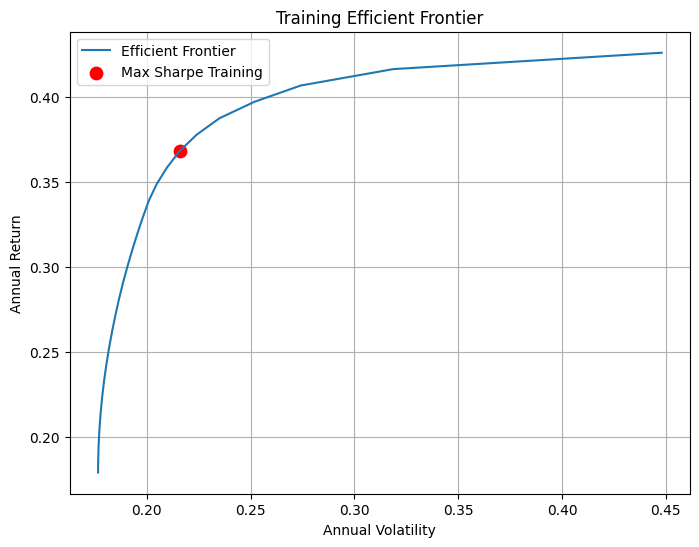

### 🧮 Max-Sharpe Portfolio Weights (Training)

,weight
INFY.NS,37.22%
ASIANPAINT.NS,30.11%
BHARTIARTL.NS,14.23%
SUNPHARMA.NS,10.17%
BAJFINANCE.NS,7.52%
RELIANCE.NS,0.75%
ITC.NS,0.00%
NTPC.NS,0.00%
MARUTI.NS,0.00%
ONGC.NS,0.00%


<Figure size 1000x600 with 0 Axes>

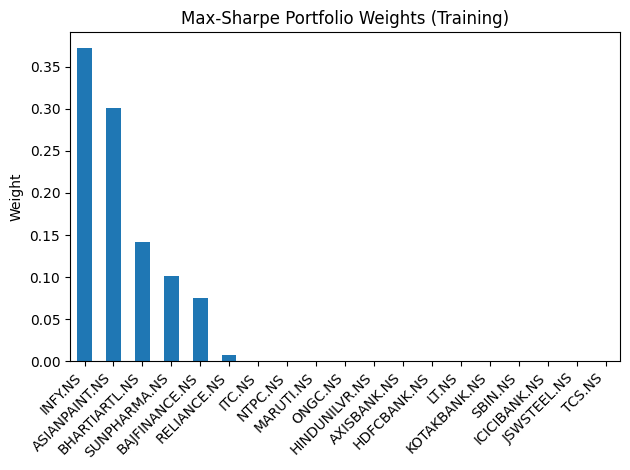

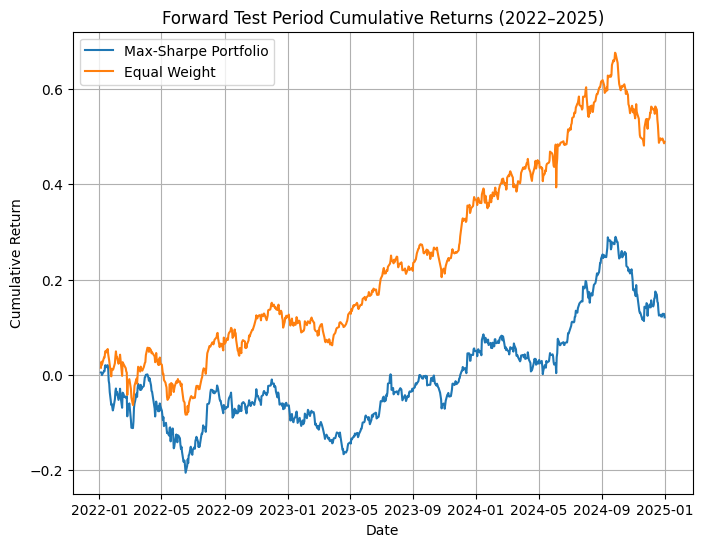

In [7]:
# ==============================
# CELL 1: Imports & Setup
# ==============================
# Optional: yfinance for real data
try:
    import yfinance as yf
    YFINANCE_AVAILABLE = True
except ImportError:
    YFINANCE_AVAILABLE = False
    print("yfinance not installed; will use simulated data.")

from IPython.display import display, Markdown

TRADING_DAYS_PER_YEAR = 252
RISK_FREE_RATE = 0.06  # annual
RESULTS_DIR = "mvo_backtest_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Sample NIFTY50 tickers (Yahoo format)
tickers = [
    "RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "ICICIBANK.NS", "HINDUNILVR.NS",
    "INFY.NS", "KOTAKBANK.NS", "SBIN.NS", "AXISBANK.NS", "LT.NS", "ITC.NS", "BAJFINANCE.NS", "BHARTIARTL.NS", "ASIANPAINT.NS",
    "MARUTI.NS", "NTPC.NS", "JSWSTEEL.NS", "ONGC.NS", "SUNPHARMA.NS"
]

# ==============================
# CELL 2: Data Download / Simulated
# ==============================
def download_prices(tick_list, start, end):
    if not YFINANCE_AVAILABLE:
        raise RuntimeError("yfinance not installed")
    data = yf.download(tick_list, start=start, end=end, progress=False, auto_adjust=False)
    if data.empty:
        raise RuntimeError("Downloaded data empty")
    if isinstance(data.columns, pd.MultiIndex):
        prices = data["Close"]
    else:
        prices = data.copy()
    prices = prices.ffill().bfill()
    return prices

def make_simulated_prices(n_assets=10, n_days=TRADING_DAYS_PER_YEAR*3, seed=123):
    rng = np.random.default_rng(seed)
    dt = 1 / TRADING_DAYS_PER_YEAR
    mu = rng.normal(0.08, 0.02, size=n_assets)
    sigma = rng.uniform(0.15, 0.4, size=n_assets)
    S0 = rng.uniform(50, 500, size=n_assets)
    returns = rng.normal(loc=mu*dt, scale=sigma*np.sqrt(dt), size=(n_days, n_assets))
    logS = np.log(S0) + returns.cumsum(axis=0)
    prices = np.exp(logS)
    dates = pd.bdate_range(end=datetime.date(2022,1,1), periods=n_days)
    cols = [f"SIM_{i+1}" for i in range(n_assets)]
    return pd.DataFrame(prices, index=dates, columns=cols)

# Training period: 3 years prior to 2022
train_start = "2019-01-01"
train_end = "2021-12-31"

try:
    prices_train = download_prices(tickers, train_start, train_end)
except:
    print("Using simulated training data")
    prices_train = make_simulated_prices(n_assets=len(tickers))

# Test period: 2022–2025
test_start = "2022-01-01"
test_end = "2025-01-01"

try:
    prices_test = download_prices(tickers, test_start, test_end)
except:
    print("Using simulated test data")
    prices_test = make_simulated_prices(n_assets=len(prices_train.columns), n_days=TRADING_DAYS_PER_YEAR*3)

# ==============================
# CELL 3: Compute training returns, mu, covariance
# ==============================
daily_train = prices_train.pct_change().dropna(how='all')
daily_train = daily_train.dropna(axis=1, how='all')
assets = list(daily_train.columns)

mu_train = daily_train.mean() * TRADING_DAYS_PER_YEAR
cov_train = daily_train.cov() * TRADING_DAYS_PER_YEAR
n = len(mu_train)
Sigma = cov_train.values
mu = mu_train.values

# ==============================
# CELL 4: CVXPY Optimization (long-only, sum=1)
# Find efficient frontier and max-Sharpe portfolio
# ==============================

# ==============================
# CELL: Robust CVXPY Optimization (SCS only)
# ==============================
import warnings

w = cp.Variable(n)

# Long-only, fully-invested constraints
constraints = [cp.sum(w) == 1, w >= 0]

# Sweep target returns to build efficient frontier
TARGET_POINTS = 50
ret_min = np.min(mu)
ret_max = np.max(mu)
target_returns = np.linspace(ret_min, ret_max, TARGET_POINTS)

frontier_weights = []
frontier_risks = []
frontier_returns = []

# Regularize covariance matrix for numerical stability
Sigma = 0.5 * (Sigma + Sigma.T)
Sigma += np.eye(n) * 1e-4  # small ridge to ensure PSD

for targ in target_returns:
    obj = cp.quad_form(w, Sigma)
    prob = cp.Problem(cp.Minimize(obj), constraints + [mu @ w >= targ])

    try:
        # Use SCS solver (installed by default with CVXPY)
        prob.solve(solver=cp.SCS, warm_start=True, verbose=False)
    except cp.SolverError:
        # fallback to default solver if SCS fails
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            prob.solve(warm_start=True, verbose=False)

    # Skip if solver failed
    if w.value is None:
        continue

    w_opt = np.array(w.value).flatten()
    w_opt[w_opt < 1e-8] = 0
    w_opt /= w_opt.sum()  # renormalize

    port_ret = float(mu @ w_opt)
    port_vol = float(np.sqrt(w_opt @ Sigma @ w_opt))

    frontier_weights.append(w_opt)
    frontier_returns.append(port_ret)
    frontier_risks.append(port_vol)

# Convert lists to arrays
frontier_weights = np.array(frontier_weights)
frontier_returns = np.array(frontier_returns)
frontier_risks = np.array(frontier_risks)

# Compute Sharpe ratios
sharpes = (frontier_returns - RISK_FREE_RATE) / frontier_risks
imax = np.nanargmax(sharpes)

# Max-Sharpe portfolio
w_star = frontier_weights[imax]
ret_star = frontier_returns[imax]
vol_star = frontier_risks[imax]
sharpe_star = sharpes[imax]

print("Robust SCS optimization complete.")
print(f"Max-Sharpe portfolio: return {ret_star:.2%}, vol {vol_star:.2%}, Sharpe {sharpe_star:.3f}")

# ==============================
# CELL 5: Evaluate performance on test period (forward 3 years)
# ==============================
daily_test = prices_test[assets].pct_change().dropna(how='all')

port_daily_test = daily_test.values @ w_star
port_cum_test = (1+port_daily_test).cumprod() - 1

ew_daily_test = daily_test.values @ (np.repeat(1/n, n))
ew_cum_test = (1+ew_daily_test).cumprod() - 1

# Annualized return and volatility for test period
n_days_test = daily_test.shape[0]
ann_return_test = (1+port_cum_test[-1])**(TRADING_DAYS_PER_YEAR/n_days_test) -1
ann_vol_test = np.std(port_daily_test)*np.sqrt(TRADING_DAYS_PER_YEAR)
sharpe_test = (ann_return_test - RISK_FREE_RATE)/ann_vol_test

# ==============================
# CELL 6: Report / Plots
# ==============================
display(Markdown("## 📊 Backtest MVO Report"))

# Key metrics
summary_table = pd.DataFrame({
    "Training Max-Sharpe Portfolio": {
        "Return (ann)": ret_star,
        "Volatility (ann)": vol_star,
        "Sharpe": sharpe_star,
    },
    "Test Period Realized": {
        "Return (ann)": ann_return_test,
        "Volatility (ann)": ann_vol_test,
        "Sharpe": sharpe_test,
    },
    "Equal Weight (Test)": {
        "Return (ann)": (1+ew_cum_test[-1])**(TRADING_DAYS_PER_YEAR/n_days_test)-1,
        "Volatility (ann)": np.std(ew_daily_test)*np.sqrt(TRADING_DAYS_PER_YEAR),
        "Sharpe": ((1+ew_cum_test[-1])**(TRADING_DAYS_PER_YEAR/n_days_test)-1 - RISK_FREE_RATE)/(np.std(ew_daily_test)*np.sqrt(TRADING_DAYS_PER_YEAR))
    }
}).T
display(summary_table.style.format("{:.2%}", subset=["Return (ann)", "Volatility (ann)"])
                        .format("{:.3f}", subset=["Sharpe"]))

# Efficient Frontier
plt.figure(figsize=(8,6))
plt.plot(frontier_risks, frontier_returns, label="Efficient Frontier")
plt.scatter(vol_star, ret_star, color='red', s=80, label="Max Sharpe Training")
plt.xlabel("Annual Volatility")
plt.ylabel("Annual Return")
plt.title("Training Efficient Frontier")
plt.legend()
plt.grid(True)
plt.show()

# Portfolio weights
weights_df = pd.DataFrame(index=assets, data=w_star, columns=["weight"])
weights_df = weights_df.sort_values("weight", ascending=False)

display(Markdown("### 🧮 Max-Sharpe Portfolio Weights (Training)"))
display(weights_df.style.format("{:.2%}"))

plt.figure(figsize=(10,6))
weights_df.plot(kind="bar", legend=False)
plt.ylabel("Weight")
plt.title("Max-Sharpe Portfolio Weights (Training)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Cumulative return plot (forward test)
plt.figure(figsize=(8,6))
plt.plot(daily_test.index, port_cum_test, label="Max-Sharpe Portfolio")
plt.plot(daily_test.index, ew_cum_test, label="Equal Weight")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Forward Test Period Cumulative Returns (2022–2025)")
plt.legend()
plt.grid(True)
plt.show()



In [9]:
# ==============================
# CELL: Statistical Analysis of Portfolio Returns
# ==============================
import seaborn as sns
from scipy.stats import skew, kurtosis

# Correct selection of portfolio stocks
selected_assets = [a for a, wgt in zip(assets, w_star) if wgt > 1e-3]  # only non-zero weight assets
weights_selected = np.array([w_star[assets.index(a)] for a in selected_assets])

display(Markdown(f"## 🔍 Statistical Analysis of Selected Portfolio Stocks ({len(selected_assets)} assets)"))

# Training and test returns for only the portfolio stocks
train_returns_selected = daily_train[selected_assets]
test_returns_selected = daily_test[selected_assets]

# Portfolio-level daily returns (weighted)
port_train_daily = train_returns_selected.values @ weights_selected
port_test_daily = test_returns_selected.values @ weights_selected

# ---------------------------
# Portfolio statistics
# ---------------------------

port_stats = pd.DataFrame({
    "Training": [port_train_daily.mean()*TRADING_DAYS_PER_YEAR,
                 np.std(port_train_daily)*np.sqrt(TRADING_DAYS_PER_YEAR),
                 (port_train_daily.mean()*TRADING_DAYS_PER_YEAR-RISK_FREE_RATE)/(np.std(port_train_daily)*np.sqrt(TRADING_DAYS_PER_YEAR))],
    "Test": [port_test_daily.mean()*TRADING_DAYS_PER_YEAR,
             np.std(port_test_daily)*np.sqrt(TRADING_DAYS_PER_YEAR),
             (port_test_daily.mean()*TRADING_DAYS_PER_YEAR-RISK_FREE_RATE)/(np.std(port_test_daily)*np.sqrt(TRADING_DAYS_PER_YEAR))]
}, index=["Annualized Return", "Annualized Volatility", "Sharpe"])

display(Markdown("### Portfolio-level Performance Comparison"))
display(
    port_stats.style.format("{:.2%}", subset=["Training","Test"])
              .format("{:.3f}", subset=["Training","Test"])
)



## 🔍 Statistical Analysis of Selected Portfolio Stocks (6 assets)

### Portfolio-level Performance Comparison

,Training,Test
Annualized Return,0.368,0.051
Annualized Volatility,0.216,0.156
Sharpe,1.429,-0.058


#### Analyzing the return statistics of benchmark index and portfolio constituents

In [10]:
# Define the ticker symbol for Nifty 50
nifty_ticker = "^NSEI"

# Define the training and testing periods
train_start = "2019-01-01"
train_end = "2021-12-31"
test_start = "2022-01-01"
test_end = "2025-01-01"

def periods_return_statistics(nifty_ticker):

  # Download Nifty 50 data for the training period
  nifty_train = yf.download(nifty_ticker, start=train_start, end=train_end, auto_adjust=False)

  # Download Nifty 50 data for the testing period
  nifty_test = yf.download(nifty_ticker, start=test_start, end=test_end, auto_adjust=False)

  # Display the first few rows of the training data
  #print(nifty_train.head())

  # Display the first few rows of the testing data
  #print(nifty_test.head())

  def compute_returns(prices):
      return prices.pct_change().dropna()

  def summarize_returns(returns):
      """Return annualized mean, volatility, and cumulative return."""
      return {
          "Mean Return": returns.mean() * 252,  # annualized
          "Volatility": returns.std() * np.sqrt(252),  # annualized
          "Cumulative Return": (1 + returns).prod() - 1
      }

  #nifty_train_prices = prices_train['Adj Close']
  #nifty_test_prices = prices_test['Adj Close']
  try:
    nifty_train_prices = prices_train['Adj Close']
    nifty_test_prices = prices_test['Adj Close']
  except KeyError as e:
    nifty_train_prices = nifty_train[('Adj Close', nifty_ticker)]
    nifty_test_prices  = nifty_test[('Adj Close', nifty_ticker)]

  nifty_returns_train = compute_returns(nifty_train_prices)
  nifty_returns_test = compute_returns(nifty_test_prices)


  # Summarize statistics
  stats_train = summarize_returns(nifty_returns_train)
  stats_test = summarize_returns(nifty_returns_test)

  #print("Nifty statistics - Training period:")
  #print(stats_train)

  #print("\nNifty statistics - Test period:")
  #print(stats_test)
  print("\n","="*20, "\n\nStock ticker: ", nifty_ticker)

  # Simple market trend check
  def market_trend(cum_return):
      if cum_return < -0.00:
          return "Down"
      elif cum_return < 0.05:
          return "Sideways"
      else:
          return "Up"

  print(f"\nMarket trend in training period: {market_trend(stats_train['Cumulative Return'])}")
  print(f"Market trend in test period: {market_trend(stats_test['Cumulative Return'])}")

  train_trend = market_trend(stats_train['Cumulative Return'])
  test_trend = market_trend(stats_test['Cumulative Return'])

  # Create side-by-side DataFrame
  report = pd.DataFrame({
      'Training Period': stats_train,
      'Test Period': stats_test
  })

  # Add market trend as an extra row
  report.loc['Market Trend'] = [train_trend, test_trend]

  # Format as percentages for readability
  report_formatted = report.copy()
  for col in ['Training Period', 'Test Period']:
      report_formatted.loc[['Mean Return', 'Volatility', 'Cumulative Return'], col] *= 100
      report_formatted[col] = report_formatted[col].round(2)

  print(f"\nNifty Summary Report:\ntraining period: {train_start}:{train_end}\ntesting period {test_start}:{test_end}\n")
  print(report_formatted)



In [12]:
periods_return_statistics(nifty_ticker)

i = 0
for nifty_ticker in selected_assets:
  periods_return_statistics(nifty_ticker)
  print("\nStock ", nifty_ticker, "weight in portfolio", round(weights_selected[i],2))
  i+=1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Stock ticker:  ^NSEI

Market trend in training period: Up
Market trend in test period: Up

Nifty Summary Report:
training period: 2019-01-01:2021-12-31
testing period 2022-01-01:2025-01-01

                  Training Period Test Period
Mean Return             18.364145   11.023659
Volatility              21.848245   14.057344
Cumulative Return       59.406525   34.149576
Market Trend                   Up          Up


Stock ticker:  ASIANPAINT.NS

Market trend in training period: Up
Market trend in test period: Down

Nifty Summary Report:
training period: 2019-01-01:2021-12-31
testing period 2022-01-01:2025-01-01

                  Training Period Test Period
Mean Return             35.372144  -10.508253
Volatility              28.671888   21.914017
Cumulative Return      150.293023  -31.522385
Market Trend                   Up        Down

Stock  ASIANPAINT.NS weight in portfolio 0.3


Stock ticker:  BAJFINANCE.NS

Market trend in training period: Up
Market trend in test period: Dow


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Stock ticker:  INFY.NS

Market trend in training period: Up
Market trend in test period: Up

Nifty Summary Report:
training period: 2019-01-01:2021-12-31
testing period 2022-01-01:2025-01-01

                  Training Period Test Period
Mean Return              42.76922    5.228346
Volatility              30.652883   24.724202
Cumulative Return      205.345947      6.5327
Market Trend                   Up          Up

Stock  INFY.NS weight in portfolio 0.37


Stock ticker:  RELIANCE.NS

Market trend in training period: Up
Market trend in test period: Up

Nifty Summary Report:
training period: 2019-01-01:2021-12-31
testing period 2022-01-01:2025-01-01

                  Training Period Test Period
Mean Return             32.123292    6.017496
Volatility              34.731632   22.606586
Cumulative Return      115.333852   10.681687
Market Trend                   Up          Up

Stock  RELIANCE.NS weight in portfolio 0.01


Stock ticker:  SUNPHARMA.NS

Market trend in training period

### Reporting the findings

# Portfolio Performance Analysis: 2019–2025  
**Report Date:** September 24, 2025  
**Subject:** Analysis of a Six-Stock Portfolio vs. Nifty 50 (^NSEI) Benchmark  

This report summarizes the performance of a portfolio consisting of six NSE-listed stocks against the Nifty 50 index. The analysis covers a **training period (Jan 1, 2019 – Dec 31, 2021)** and a **testing period (Jan 1, 2022 – Jan 1, 2025)**.  

---

## 1. Benchmark Performance: Nifty 50 (^NSEI)  

The Nifty 50 index, serving as the market benchmark, demonstrated a consistent upward trend across both periods.  

- **Training Period (2019–2021):**  
  - Mean Return: **18.36%**  
  - Volatility: **21.85%**  
  - Cumulative Return: **59.41%**  

- **Test Period (2022–2025):**  
  - Mean Return: **11.02%**  
  - Volatility: **14.06%**  

📌 *Insight:* While the market continued to grow, the **growth rate and price fluctuations were less pronounced** in the later period.  

---

## 2. Portfolio Composition  

The portfolio is concentrated in two main stocks, which together constitute **67%** of the total investment.  

| Stock Ticker   | Weight |
|----------------|--------|
| INFY.NS        | 37%    |
| ASIANPAINT.NS  | 30%    |
| BHARTIARTL.NS  | 14%    |
| SUNPHARMA.NS   | 10%    |
| BAJFINANCE.NS  | 8%     |
| RELIANCE.NS    | 1%     |

---

## 3. Individual Stock Performance Observations  

The performance of the individual stocks showed **significant divergence** during the test period.  

### ✅ Consistent Outperformers  
- **BHARTIARTL.NS** and **SUNPHARMA.NS** were the star performers.  
- Maintained high mean returns (**31.22%** and **30.19%**) with **cumulative returns over 129%**.  
- Volatility decreased → improved **risk-adjusted returns**.  

### 📉 Decelerating Performers  
- **INFY.NS** and **RELIANCE.NS** slowed sharply:  
  - INFY: Mean return dropped to **5.23%** (from 32%+ in training).  
  - RELIANCE: Mean return dropped to **6.02%** (from 42%+ in training).  
- As the largest holdings, this slowdown heavily impacted overall portfolio growth.  

### ↩️ Trend Reversals  
- **ASIANPAINT.NS** and **BAJFINANCE.NS** reversed from strong growth to **negative returns**.  
- **ASIANPAINT.NS** (-31.52% cumulative return) — a major blow as the **second-largest holding (30%)**.  
- **BAJFINANCE.NS** also posted negative mean returns.  
- Both underperformed relative to the rising Nifty 50 benchmark.  

---

## 4. Conclusion  

The analysis reveals a **performance disconnect** between the training and testing periods for key portfolio holdings.  

- **Concentration Risk:** Heavy reliance on INFY (37%) and ASIANPAINT (30%) proved detrimental.  
- **Performance Divergence:** One-third of portfolio stocks generated **negative returns** even as the Nifty 50 grew.  
- **Bright Spots:** Bharti Airtel and Sun Pharma provided strong positive offsets but could not fully counterbalance the drag.  

📌 **Summary:**  
The portfolio **underperformed against the benchmark** due to its over-reliance on past winners (INFY, ASIANPAINT) that later faltered. While diversification helped, concentration risk and performance reversals left the portfolio vulnerable to shifting market dynamics.  


# Possible Solutions to Make Portfolio Robust

---

## 1. Diversification across sectors & macro cycles  
- **What:** Include stocks/assets that perform differently under various market conditions (cyclical, defensive, counter-cyclical).  
- **How:** Add fixed income, gold, or other hedges to reduce dependence on bull markets.  
- **Why:** Reduces portfolio sensitivity to any single sector or macro regime and lowers portfolio-level volatility.

---

## 2. Dynamic allocation & risk management  
- **Adjust weights by market conditions:** Reduce weights in cyclical or richly priced stocks when market indicators show overheating.  
- **Implement exposure limits:** Cap individual stock or sector exposure (e.g., 20–30%) to avoid concentration risk.  
- **Use stop / risk triggers:** Combine time-based rules with threshold triggers to react to large deviations.

---

## 3. Factor-based or multi-strategy approach  
- **Beyond past returns:** Include stocks with low correlation to the portfolio or those exhibiting defensive factors (dividends, stable cash flow, low beta).  
- **Multi-strategy layering:** Combine value, quality, momentum, and defensive exposures to reduce single-factor failure risk.

---

## 4. Stress-test portfolio on down/sideways markets  
- **Backtest severe scenarios:** Simulate performance across bear markets, sharp drawdowns, and sideways regimes.  
- **Identify vulnerabilities:** Pinpoint which holdings are most likely to underperform in a downturn and pre-emptively adjust weights.  
- **Scenario examples:** sector-specific crash, interest-rate shock, liquidity squeeze, prolonged stagnation.

---

## 5. Include risk-adjusted performance metrics  
- Use metrics beyond mean return: **Sharpe ratio, Sortino ratio, maximum drawdown, Calmar ratio,** and **risk contribution**.  
- This prevents over-reliance on high-return but high-volatility names and highlights true risk-adjusted winners.

---

## ✅ Summary: Why underperformance happened & how to improve  
- **Why:** Downtrend in the test period + concentration in cyclical/large-cap names.  
- **How to improve:**  
  - Diversify across sectors/cycles.  
  - Cap individual stock weights.  
  - Add defensive/resilient assets (bonds, gold, cash buffers).  
  - Monitor risk-adjusted metrics, not just returns.

---

# Rebalancing Frequency — Reduce impact of underperformers over multi-year horizons

> Rebalancing is a primary operational tool to limit concentration risk and lock gains from winners while trimming laggards.

### Key Considerations for Rebalancing

**Objective**  
- Reduce concentration risk and lock in gains from outperformers.  
- Limit long exposures to large losers (e.g., INFY / ASIANPAINT scenarios).

**Trade-offs**  
- **Frequent rebalancing (monthly):**  
  - Pros: Reacts quickly to underperformance.  
  - Cons: Higher transaction costs, tax events, potential “noise trading.”  
- **Infrequent rebalancing (annual):**  
  - Pros: Lower costs, simple.  
  - Cons: Longer exposure to underperformers, larger drift.

**Market-cycle alignment**  
- Rebalance more often during volatile or deteriorating markets.  
- Allow winners to compound during sustained bull runs with lighter rebalancing.

---

### Typical Rebalancing Guidelines

| Horizon               | Pros                                           | Cons                         | Use Case                                |
|-----------------------|------------------------------------------------|------------------------------|-----------------------------------------|
| **Monthly / Quarterly** | Quickly reacts to market changes; reduces concentration | Higher costs                 | Active portfolios / volatile sectors    |
| **Semi-Annual (6 mo)** | Balance responsiveness and cost                | May lag during sharp downturns | Moderate-volatility markets             |
| **Annual**            | Lowest cost, simple                             | Long exposure to underperformers | Stable, long-term buy-and-hold portfolios |

---

## Recommended Approach for the Portfolio

**Baseline (3-year view):**  
- **Quarterly → Semi-annual** rebalancing is usually optimal: balances responsiveness and trading cost.  
- This frequency allows trimming large positions in underperformers (e.g., ASIANPAINT / BAJFINANCE) before they dominate returns.

**Dynamic rebalancing (best practice):**  
- Combine **time-based** (quarterly) + **threshold-based** triggers:  
  - Rebalance if any stock weight deviates **±5–10%** from target.  
  - This trims rapid overweighting and restores intended diversification.

**Sector / Factor check at rebalancing:**  
- Monitor sector concentration and factor drift.  
- If macro indicators point to slowdown, tilt toward defensive factors (low beta, high quality, dividends).

---

## Rule of Thumb
- **Quarterly:** Good balance between responsiveness and cost, especially in turbulent markets.  
- **Semi-annual:** Lower cost, still addresses major drifts.  
- **Annual:** Acceptable for very stable, long-horizon portfolios — *but risky when large losers appear*.  

---

## Final Notes
- Rebalancing policy should be documented, backtested, and include clear thresholds for action.  
- Combine quantitative rules (weights, volatility triggers) with qualitative checks (macro outlook, company fundamentals).  
- Track **net-of-cost** performance after rebalancing to ensure the chosen cadence adds value.
